# Анализ датасета 1985 Ward's Automotive Yearbook

## Подготовка окружения и импортирование данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation, linear_model, ensemble
from sklearn.utils import shuffle
%matplotlib inline

/home/demi/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open('names.txt', 'r') as fin:
    names = list([line.strip() for line in fin])

In [3]:
# Импортируем датасет, заменяя вопросительные знаки на NaN

data = pd.read_csv('imports-85.data', na_values = ['?'], names = names)
data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


 Описание признаков  
 
      1. symboling:                -3, -2, -1, 0, 1, 2, 3.
      2. normalized-losses:        continuous from 65 to 256.
      3. make:                     alfa-romero, audi, bmw, chevrolet, dodge, honda, isuzu, jaguar, 
                                   mazda, mercedes-benz, mercury,mitsubishi, nissan, peugot, plymouth, 
                                   porsche, renault, saab, subaru, toyota, volkswagen, volvo
      4. fuel-type:                diesel, gas.
      5. aspiration:               std, turbo.
      6. num-of-doors:             four, two.
      7. body-style:               hardtop, wagon, sedan, hatchback, convertible.
      8. drive-wheels:             4wd, fwd, rwd.
      9. engine-location:          front, rear.
      10. wheel-base:               continuous from 86.6 120.9.
      11. length:                   continuous from 141.1 to 208.1.
      12. width:                    continuous from 60.3 to 72.3.
      13. height:                   continuous from 47.8 to 59.8.
      14. curb-weight:              continuous from 1488 to 4066.
      15. engine-type:              dohc, dohcv, l, ohc, ohcf, ohcv, rotor.
      16. num-of-cylinders:         eight, five, four, six, three, twelve, two.
      17. engine-size:              continuous from 61 to 326.
      18. fuel-system:              1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi.
      19. bore:                     continuous from 2.54 to 3.94.
      20. stroke:                   continuous from 2.07 to 4.17.
      21. compression-ratio:        continuous from 7 to 23.
      22. horsepower:               continuous from 48 to 288.
      23. peak-rpm:                 continuous from 4150 to 6600.
      24. city-mpg:                 continuous from 13 to 49.
      25. highway-mpg:              continuous from 16 to 54.
      26. price:                    continuous from 5118 to 45400.

In [4]:
data.shape

(205, 26)

## Анализ исходных данных

Первая задача, которая просится к решению при первом просмотре исходных данных - анализ стоимость машины в зависимости от всех признаков (марка машины, мощность,тип двигателя и так далее) и определение наиболее значительных из них. Но эта задача носит скорее любопытный характер, нежели практически значимый.

Более полезной задачей для страховых компаний выглядит прогноз рейтинга риска (symboling) в зависимости от параметров.

Бытовой пользой обладает задача прогнозирования среднегодовой стоимости обслуживания автомобиля (normalized-losses).

Фанатам технической стороны автомобиля понравится поиск зависимости мощности двигателя и крутящего момента от различных параметров двигателя и топливной системы.

Экономные водители в первую очередь посчитают, какие параметры конструкции автомобиля повлияют на расход топлива, а также взглянули бы на разницу в значимых параметрах между расходом в городе и на трассе. Если бы в числе признаков были выбросы углекислого газа, то к ним бы присоединились экологи, которые выяснили бы какие марки автомобилей самые "грязные".

В качестве рабочей задачи выберу задачу прогноза среднегодовой стоимости обслуживания автомобиля. В этом случае мы решаем задачу регрессии с вектором ответов - normalized-losses.

Подготовим данные для обработки:

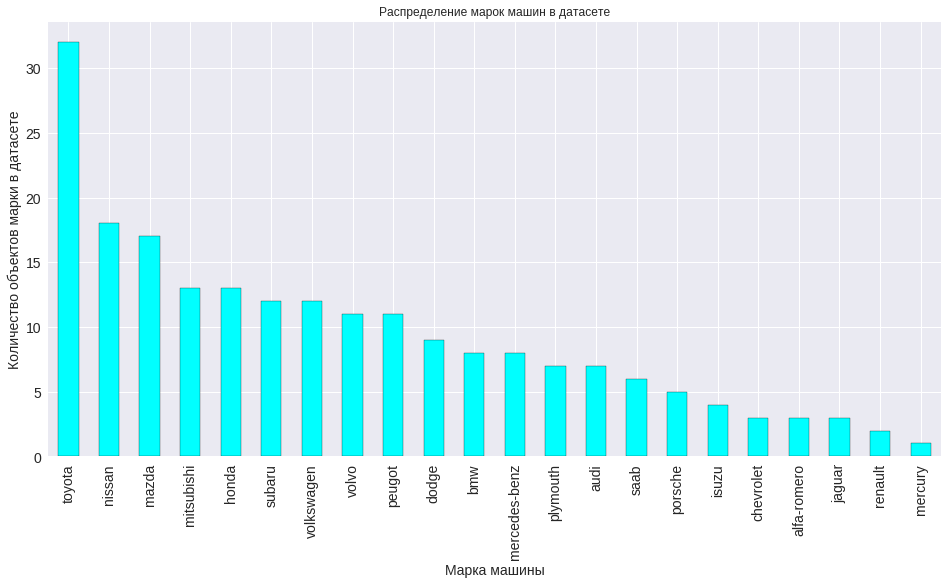

In [5]:
# Посмотрим на данные внимательнее
# Сперва оценим оценим распределение марок автомобилей в себе. Это не очень полезно практически, зато интересно.

data.make.value_counts().plot(kind = 'bar', figsize = (16, 8), color = 'aqua', edgecolor = 'black',
                             title = u'Распределение марок машин в датасете', fontsize = 14)
plt.xlabel(u'Марка машины', fontsize = 14)
plt.ylabel(u'Количество объектов марки в датасете', fontsize = 14)
plt.show()

In [6]:
# Разобьем признаки на вещественные и категориальные

real_features = ['wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore',
                'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
category_features = ['symboling', 'make', 'body-style', 'drive-wheels', 'engine-type', 
                     'num-of-cylinders', 'fuel-system', 'fuel-type', 'aspiration', 
                     'num-of-doors', 'engine-location']

# Поскольку на распределение марок машин мы уже посмотрели, удалим этот признак из сета визуализации

cat_features = category_features.remove('make')

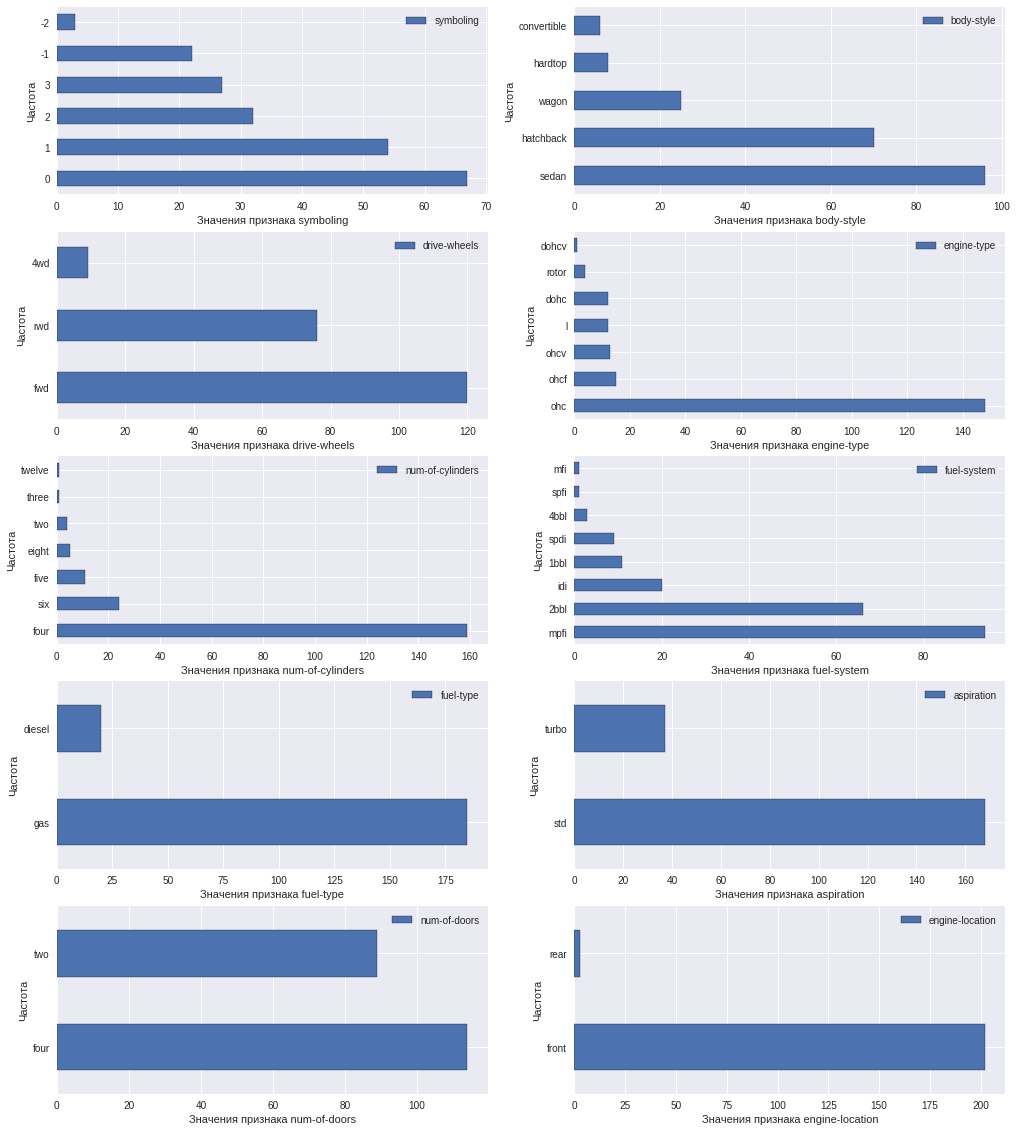

In [7]:
# Посмотрим на распределение значений остальных категориальных признаков

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(17, 20))

for idx, cat in enumerate(data[category_features]): 
    plt.subplot(5, 2, idx + 1)
    data[cat].value_counts().plot(label = cat, edgecolor = 'black', kind = 'barh')
    plt.legend()
    plt.ylabel(u'Частота')
    plt.xlabel(u'Значения признака %s' % cat)
plt.show()

По графикам видно, что некоторые из признаков распределены крайне неравномерно. К примеру, заднее расположение двигателя встречается только у трёх моделей из 205 (остальные с передним расположение). Это говорит о том, что признак engine-location неинформативен и может быть удален из анализа.

In [8]:
data['engine-location'].value_counts()

front    202
rear       3
Name: engine-location, dtype: int64

In [9]:
category_feat = ['symboling', 'make', 'body-style', 'drive-wheels', 'engine-type', 
                     'num-of-cylinders', 'fuel-system', 'fuel-type', 'aspiration', 'num-of-doors']

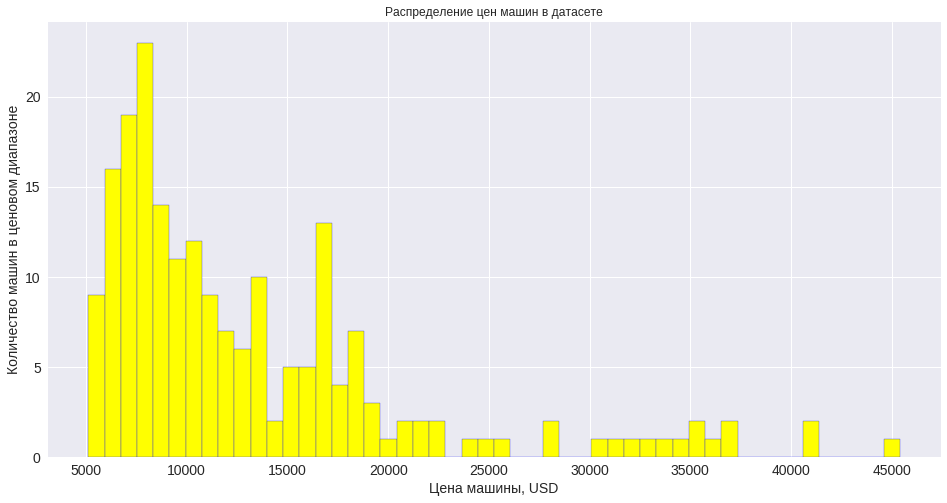

In [10]:
# Далее посмотрим на распределение вещественных признаков
# В первую очередь, на цену

data.price.plot(kind = 'hist', bins = 50, figsize = (16, 8), color = 'yellow', edgecolor = 'blue',
                             title = u'Распределение цен машин в датасете', fontsize = 14, grid = True)
plt.xlabel(u'Цена машины, USD', fontsize = 14)
plt.ylabel(u'Количество машин в ценовом диапазоне', fontsize = 14)
plt.show()

Как видим, большая часть машин представлена в относительно экономичном ценовом диапазоне. Следовательно, можно не опасаться большого количества выбросов из-за специфичности дорогих кастомных машин.

In [11]:
# Посмотрим на распределение значений остальных вещественных признаков

real_features = ['wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore',
                'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

real_features1 = ['wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore']
real_features2 = ['stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

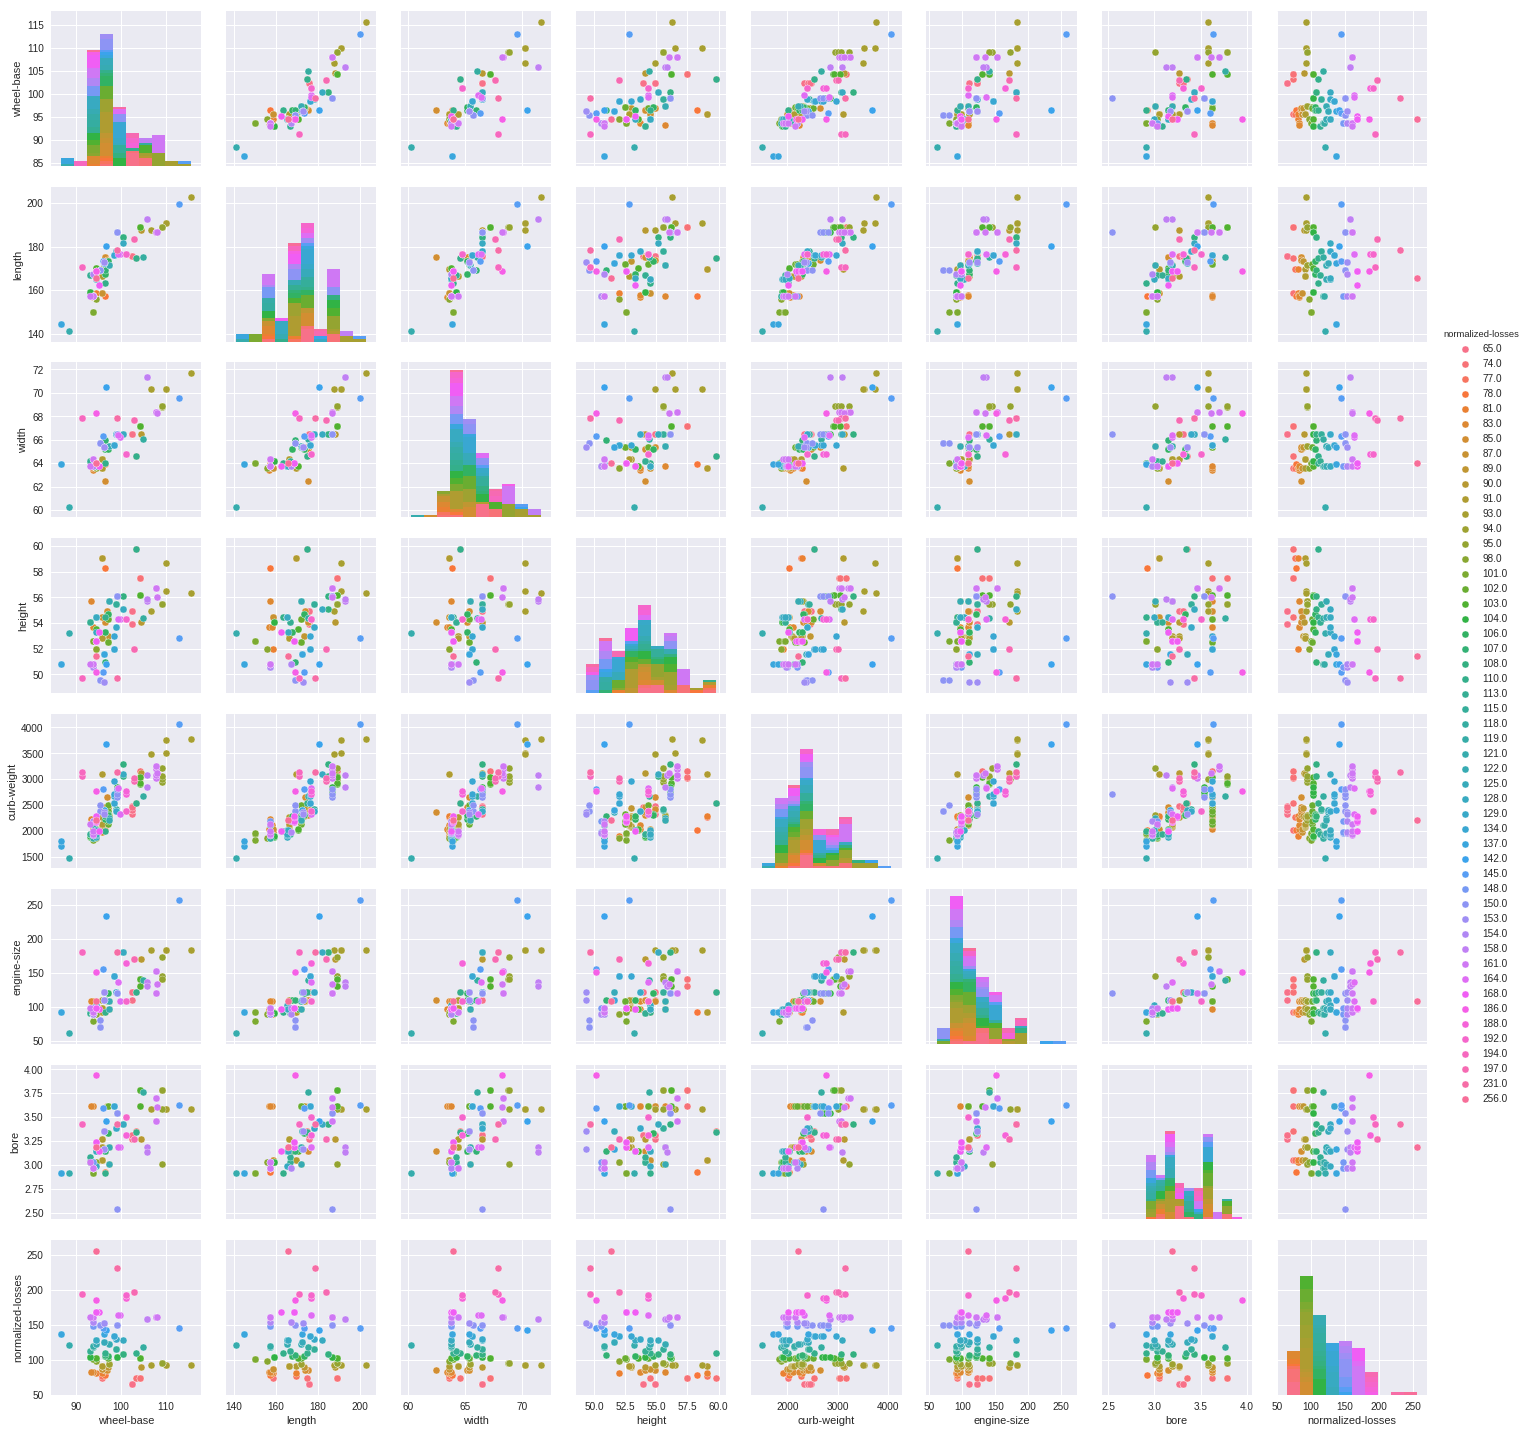

In [12]:
sns.pairplot(data[real_features1 + ['normalized-losses']], hue='normalized-losses')

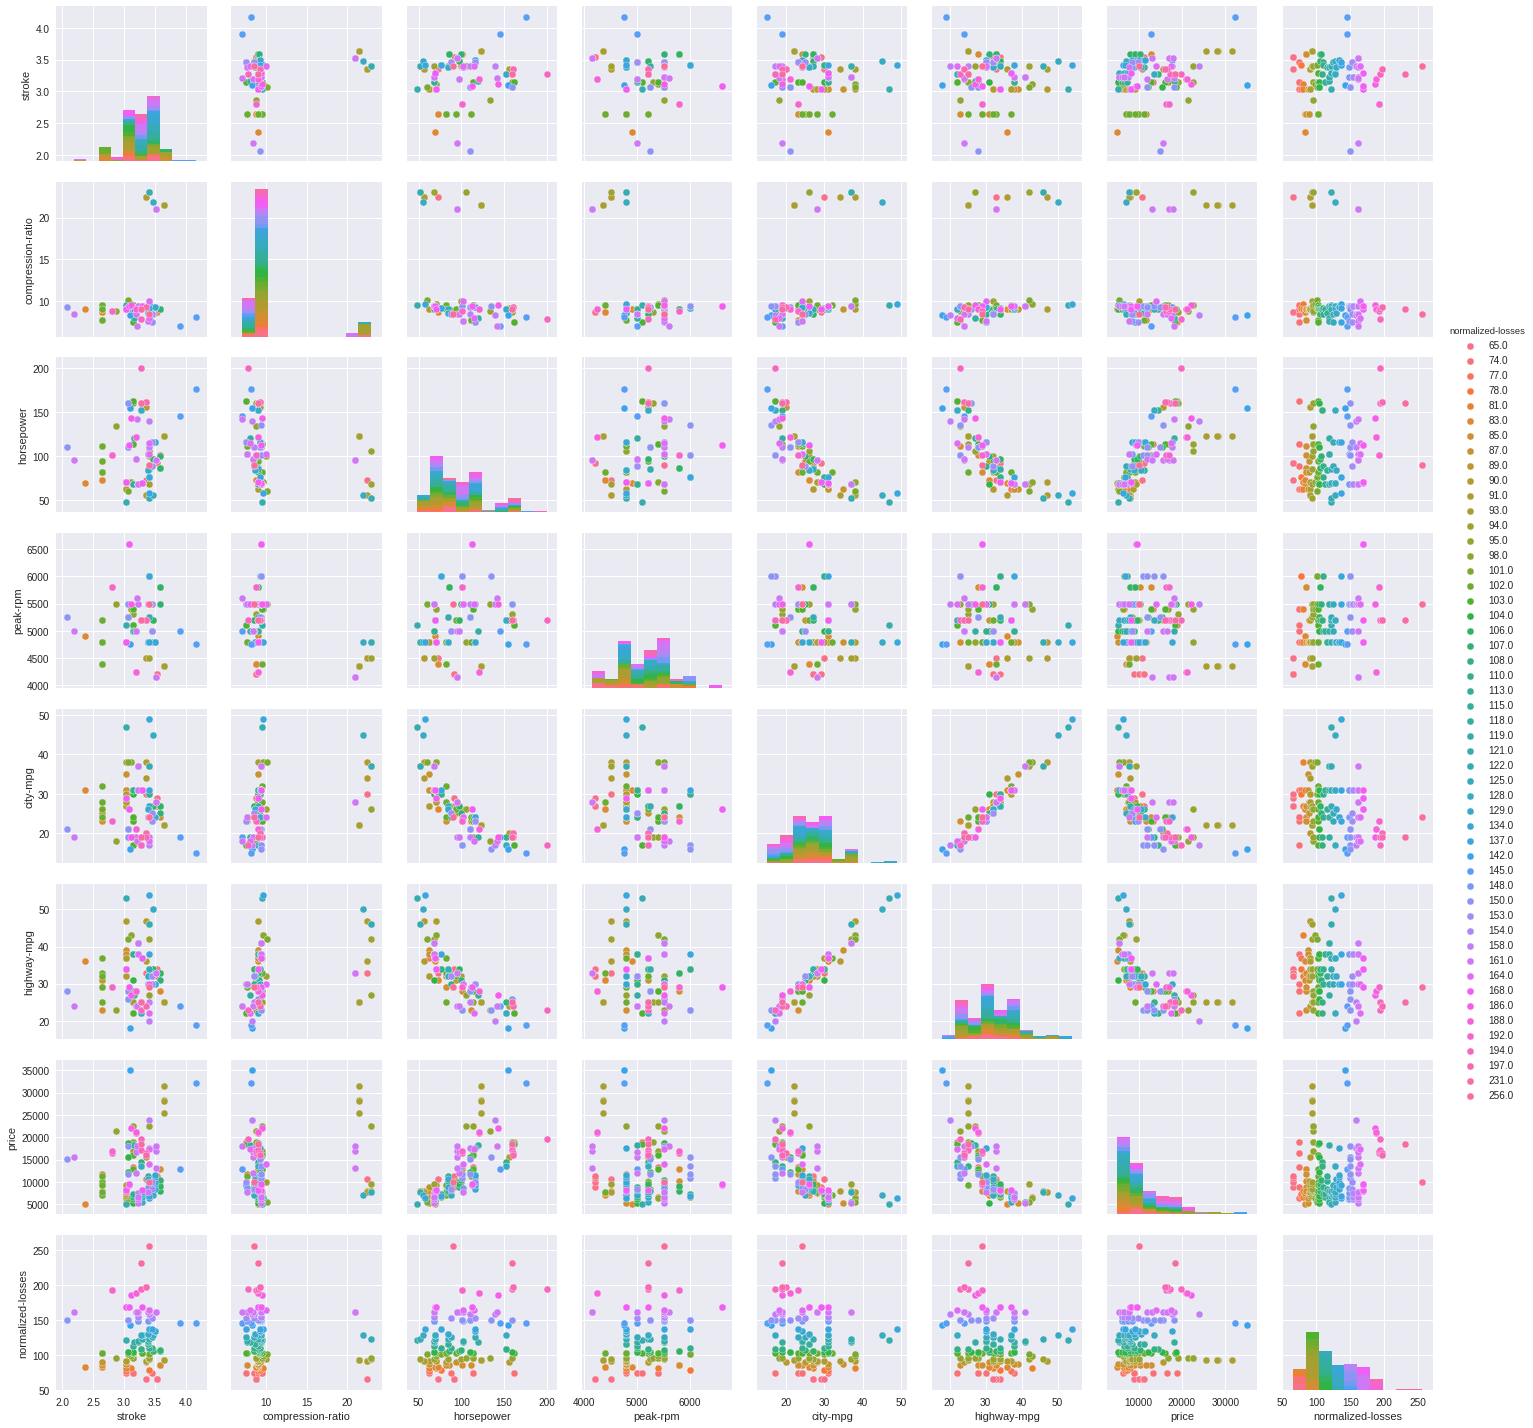

In [13]:
sns.pairplot(data[real_features2 + ['normalized-losses']], hue='normalized-losses');

Даже по неполным графикам видно, что некоторые пары признаков явно линейно коррелированы. Проведем корреляционный анализ более формально

## Подготовка данных

In [14]:
# Чтобы избежать мультикорреляции и нестабильности модели, посмотрим на матрицу корреляций признаков

corr_matrix = data.corr(method = 'pearson')
corr_matrix

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
symboling,1.000000,0.528667,-0.531954,-0.357612,-0.232919,-0.541038,-0.227691,-0.105790,-0.134205,-0.008965,-0.178515,0.071622,0.274573,-0.035823,0.034606,-0.082391
normalized-losses,0.528667,1.000000,-0.074362,0.023220,0.105073,-0.432335,0.119893,0.167365,-0.036167,0.065627,-0.132654,0.295772,0.264597,-0.258502,-0.210768,0.203254
wheel-base,-0.531954,-0.074362,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.490378,0.161477,0.249786,0.352297,-0.361052,-0.470414,-0.544082,0.584642
length,-0.357612,0.023220,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.607480,0.129739,0.158414,0.555003,-0.287325,-0.670909,-0.704662,0.690628
width,-0.232919,0.105073,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559204,0.182956,0.181129,0.642482,-0.219957,-0.642704,-0.677218,0.751265
height,-0.541038,-0.432335,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.176195,-0.056999,0.261214,-0.110711,-0.322272,-0.048640,-0.107358,0.135486
curb-weight,-0.227691,0.119893,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.649045,0.168929,0.151362,0.751034,-0.266306,-0.757414,-0.797465,0.834415
engine-size,-0.105790,0.167365,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.594090,0.206675,0.028971,0.810773,-0.244618,-0.653658,-0.677470,0.872335
bore,-0.134205,-0.036167,0.490378,0.607480,0.559204,0.176195,0.649045,0.594090,1.000000,-0.055909,0.005203,0.577273,-0.264269,-0.594584,-0.594572,0.543436
stroke,-0.008965,0.065627,0.161477,0.129739,0.182956,-0.056999,0.168929,0.206675,-0.055909,1.000000,0.186170,0.090254,-0.071493,-0.042906,-0.044528,0.082310


In [15]:
# Чтобы не пропустить данных при визуальном анализе, формально выделим явно коррелирующие признаки

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix[corr_matrix.columns[i]].corr(corr_matrix[corr_matrix.columns[j]]) > 0.85:
            print (u'Корреляция между признаками %s и %s = %s' % 
            (corr_matrix.columns[i], corr_matrix.columns[j], 
             round(corr_matrix[corr_matrix.columns[i]].corr(corr_matrix[corr_matrix.columns[j]]), 3)))
    print



Корреляция между признаками wheel-base и length = 0.976
Корреляция между признаками wheel-base и width = 0.942
Корреляция между признаками wheel-base и curb-weight = 0.925
Корреляция между признаками wheel-base и bore = 0.855

Корреляция между признаками length и width = 0.985
Корреляция между признаками length и curb-weight = 0.981
Корреляция между признаками length и engine-size = 0.925
Корреляция между признаками length и bore = 0.925
Корреляция между признаками length и price = 0.928

Корреляция между признаками width и curb-weight = 0.993
Корреляция между признаками width и engine-size = 0.96
Корреляция между признаками width и bore = 0.928
Корреляция между признаками width и horsepower = 0.875
Корреляция между признаками width и price = 0.962


Корреляция между признаками curb-weight и engine-size = 0.978
Корреляция между признаками curb-weight и bore = 0.946
Корреляция между признаками curb-weight и horsepower = 0.903
Корреляция между признаками curb-weight и price = 0.978

Ко

Полагаться на голые цифры не стоит. Подключим здравый смысл. Анализ показывает, что высокой взаимной корреляцией обладают признаки колесная база, длина, ширина и вес автомобиля. Это выглядит логичным, так как от модели к модели эти параметры меняются все вместе: для одних машин они все велики, для других малы. Трудно отыскать широкую, но короткую машину. Или короткобазную, но тяжелую. Поэтому наличие всех этих признаков в одной модели будет её зашумлять.

Высокая корреляция диаметра поршня с весогабаритными характеристиками автомобиля не выглядит столь очевидной. Не углубляясь в нюансы автомобилестроения, предположим, что эта корреляция - совпадение.

Размер двигателя, диаметр поршня и мощность двигателя также имеют высокие показатели корреляции, но реальная взаимосвясь этих параметров не очевидна.

А вот расход топлива (точнее, расстояние, которое машина проходит на единице топлива) по городу и на трассе очевидно линейнейше взаимосвязаны, о чем и говорит высокое значение коэффициента корреляции. Уберем один из этих признаков.

In [16]:
# Новый набор вещественных признаков

real_feat = ['length', 'height', 'engine-size', 'bore', 'stroke', 'compression-ratio', 
             'horsepower', 'peak-rpm', 'city-mpg', 'price']

In [17]:
# Количество пустых полей для категориальных признаков

data[category_feat].isnull().sum()

symboling           0
make                0
body-style          0
drive-wheels        0
engine-type         0
num-of-cylinders    0
fuel-system         0
fuel-type           0
aspiration          0
num-of-doors        2
dtype: int64

In [18]:
# Количество пустых полей для вещественных признаков

data[real_feat].isnull().sum()

length               0
height               0
engine-size          0
bore                 4
stroke               4
compression-ratio    0
horsepower           2
peak-rpm             2
city-mpg             0
price                4
dtype: int64

Видим, что для 6 признаков, в которых есть пустые ячейки, их количество не превышает 4. Поэтому при размере датасета в 205 объектов их можно безболезненно удалить. Удаление объектов с пустыми normalized-loss значительно сократит объем данных, но поскольку в нашей задаче именно это целевой признак - придется использовать лишь те объекты, для которых значение целевого признака определено. Другим вариантом могла бы стать замена пустых значений целевого признака средним его значением по выборке.

In [19]:
df = data.dropna()
df.shape

(159, 26)

In [20]:
# Поскольку данные отсортированы по марке машины, стоит перемешать данные для более точной оценки качества
# на кросс-валидации

df_shuffled = shuffle(df, random_state = 8)

Выделим целевой признак

In [21]:
target = df_shuffled['normalized-losses']

Категориальные признаки закодируем с бинарный формат

In [22]:
# Посмотрим на количество значений категориальных признаков, чтобы понять, 
# сколько новых признаков нам добавит бинарное кодирование

cat_values = 0
for cat in category_feat:
    print (u'Признак: %s' % cat)
    print (u'Число значений признака:')
    cat_values += len(df[cat].unique())
    print (len(df[cat].unique()))
    print
print (u'Общее число значений всех категориальных признаков = %s' % cat_values)

Признак: symboling
Число значений признака:
6

Признак: make
Число значений признака:
18

Признак: body-style
Число значений признака:
5

Признак: drive-wheels
Число значений признака:
3

Признак: engine-type
Число значений признака:
5

Признак: num-of-cylinders
Число значений признака:
5

Признак: fuel-system
Число значений признака:
6

Признак: fuel-type
Число значений признака:
2

Признак: aspiration
Число значений признака:
2

Признак: num-of-doors
Число значений признака:
2

Общее число значений всех категориальных признаков = 54


Если мы захотим использовать все категориальные признаки в модели, то общее число признаков достигнет 67. Это много по сравнению с количеством объектов - 159. 

Самым простым было бы выкинуть признак make, так как в нем аж 18 значений, но есть вероятность, что марка машины оказывает влияние на стоимость обслуживания. Тем не менее, ввиду крайне малого количества объектов в выборке немного пожертвуем информативностью ради построения хоть сколь-нибудь адекватной модели. Тогда количество новых признаков уменьшится до 36.

Признак engine-location можно отбросить из-за его константности.

Попытаемся построить модели на этих признаках и посмотрим, что получится.

In [23]:
del df_shuffled['engine-location']
del df_shuffled['make']

In [24]:
category_feat.remove('make')

In [25]:
df_cat = pd.concat([pd.get_dummies(df_shuffled[col]) for col in category_feat], axis=1)
final_cat_feat = list(df_cat.columns)
df_cat.shape

(159, 36)

Разобравшись с категориальными признаками, обратимся к вещественным. Для улучшения сходимости алгоритма оптимизации отмасштабируем их 

In [26]:
scaler = StandardScaler()
df_real = pd.DataFrame(scaler.fit_transform(df_shuffled[real_feat]), columns = real_feat)

In [27]:
df_real.head()

,length,height,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,price
0,1.234988,0.973034,0.058409,0.900112,-0.565903,-0.222100,0.462530,0.293274,-0.908534,0.693639
1,-0.593184,-0.265019,-0.731978,-0.563337,0.182501,-0.196308,-0.876384,0.185582,0.736761,-0.622379
2,-0.305900,-1.635721,1.046394,2.401086,-0.429829,-0.170517,1.540193,0.831733,-1.237593,1.804344
3,-1.350570,-0.088154,-0.731978,1.200307,-2.981206,-0.299475,-0.876384,-0.460569,0.736761,-1.079938
4,-0.062144,0.796169,-0.336785,-0.413240,0.556703,-0.299475,-0.353881,0.293274,0.078643,-0.503594


In [28]:
# Убедимся, что размеры двух матриц совпадают

df_real.shape

(159, 10)

In [29]:
# Теперь объединим подготовленные сеты категориальных и отмасштабированных вещественных признаков в один сет

df_full = pd.DataFrame(np.hstack((df_real, df_cat)), columns = [real_feat + final_cat_feat])

In [30]:
df_full.head()

,length,height,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,price,...,idi,mfi,mpfi,spdi,diesel,gas,std,turbo,four,two
0,1.234988,0.973034,0.058409,0.900112,-0.565903,-0.222100,0.462530,0.293274,-0.908534,0.693639,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,-0.593184,-0.265019,-0.731978,-0.563337,0.182501,-0.196308,-0.876384,0.185582,0.736761,-0.622379,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,-0.305900,-1.635721,1.046394,2.401086,-0.429829,-0.170517,1.540193,0.831733,-1.237593,1.804344,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,-1.350570,-0.088154,-0.731978,1.200307,-2.981206,-0.299475,-0.876384,-0.460569,0.736761,-1.079938,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,-0.062144,0.796169,-0.336785,-0.413240,0.556703,-0.299475,-0.353881,0.293274,0.078643,-0.503594,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [31]:
df_full.shape

(159, 46)

## Обучение модели

В качестве модели выберем линейную регрессию. В наборе данных много нулевых значений от бинаризации категориальных признаков, а с таким набором данных линейная модели справится хорошо. К тому же, визуализация вектора коэффициентов модели дадут ей интерпретируемость, а L1-регуляризатор позволит провести отбор важных признаков.

При наличии большего количества наблюдений был бы смысл разделить выборку на обучающую и тестовую. На обучающей выборке мы бы проводили кросс-валидацию, а отложенную выборку использовали бы для теста получившейся после подбора параметров модели воизбежание гипотетического переобучения на кросс-валидации. С нашим объемом выборки такой роскоши, как отложенная выборка, мы себе позволить не можем.

In [32]:
# Для начала построим простейшую линейную модель и посмотрим на коэффициенты перед признаками

regressor = linear_model.LinearRegression()
regressor.fit(df_full, target)

big_coef = []
small_coef = []

for cat, coef in zip(df_full.columns, regressor.coef_):
    if np.abs(coef) > 21:
        big_coef.append(' '.join((str(cat), str(round(coef, 3)))))
    if np.abs(coef) < 1:
        small_coef.append(' '.join((str(cat), str(round(coef, 3)))))
        
print (u'Большие значения коэффициентов')
print ('\n'.join(str(coef) for coef in big_coef))
print
print (u'Малые значения коэффициентов')
print ('\n'.join(str(coef) for coef in small_coef))

Большие значения коэффициентов
compression-ratio -37.641
-1 -32.121
3 43.453
l 38.165
eight -23.883
six 43.742
three -46.941
idi 40.85
diesel 40.85
gas -40.85

Малые значения коэффициентов
bore -0.581
hatchback 0.162
2bbl -0.604
mpfi -0.558
spdi 0.385


Аномально больших коэффициентов не наблюдается. Зато есть коэффициенты, близкие к нулю. Это говорит об их малом влиянии на целевую переменную. В целях уменьшения количества признаков за счет удаления тех из них, которые мало влияют на целевую переменную, используем лассо-регуляризацию, которая зануляет коэффициенты при малозначащих признаках.

In [33]:
# Подберем диапазон параметра альфа регуляризатора L1 и посмотрим как он работает

alphas = np.arange(0.1, 6, 0.1)
coefs_lasso = np.zeros((alphas.shape[0], df_full.shape[1]))

for i in range(len(alphas)):
    lasso = linear_model.Lasso(alpha = alphas[i], random_state = 2)
    lasso.fit(df_full, target)
    coefs_lasso[i] = lasso.coef_
    
non_zero_coefs = []
for line in coefs_lasso:
    non_zero_coefs.append(len(line.nonzero()[0]))

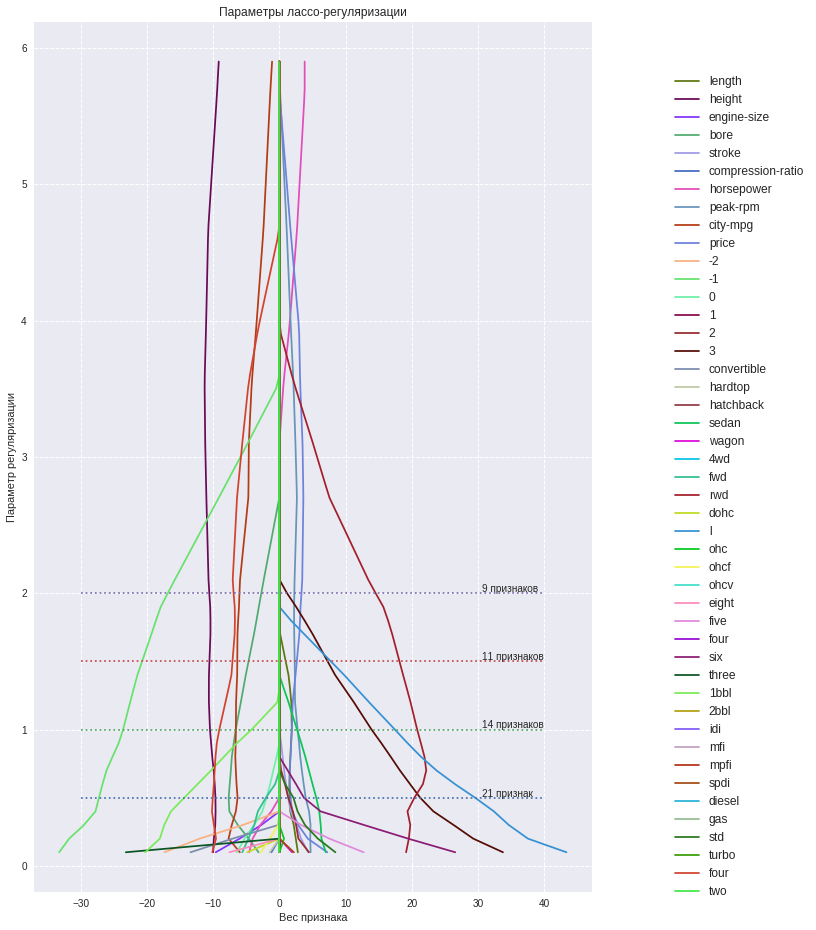

In [34]:
# Построим график, иллюстрирующий влияние параметра регуляризатора на значения коэффициентов модели

plt.figure(figsize=(10, 16))
for coef, feature in zip(coefs_lasso.T, df_full.columns):
    plt.plot(coef, alphas, label=feature, color=np.random.rand(3))
    
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95), fontsize = 12)
plt.grid(ls = 'dashed')
plt.plot([-30, 40], [0.50, 0.50], ls = 'dotted')
plt.text(30.5, 0.51, u'%s признак' % non_zero_coefs[4], fontsize = 10)
plt.plot([-30, 40], [1, 1], ls = 'dotted')
plt.text(30.5, 1.01, u'%s признаков' % non_zero_coefs[9], fontsize = 10)
plt.plot([-30, 40], [1.5, 1.5], ls = 'dotted')
plt.text(30.5, 1.51, u'%s признаков' % non_zero_coefs[14], fontsize = 10)
plt.plot([-30, 40], [2, 2], ls = 'dotted')
plt.text(30.5, 2.01, u'%s признаков' % non_zero_coefs[19], fontsize = 10)
plt.ylabel(u"Параметр регуляризации")
plt.xlabel(u'Вес признака')
plt.title(u"Параметры лассо-регуляризации")
plt.show()

Видим, что около половины признаков "схлопывается" в ноль достаточно быстро, уже к коэффициенту регуляризации 0.5. С дальнейшим увеличением параметра регуляризации количество ненулевых весов уменьшается медленно.

/home/demi/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


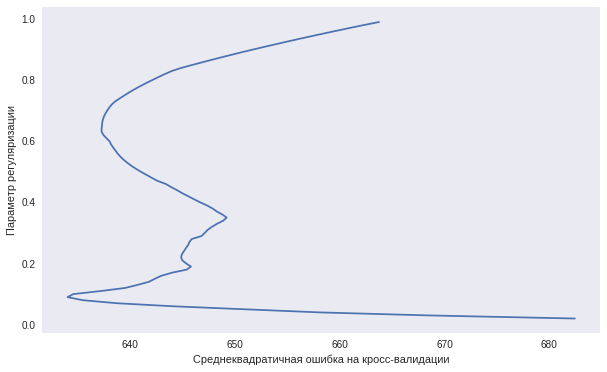

In [35]:
# Проведем подбор параметра регуляризации на кросс-валидации более формально
# Выберем 3 фолда для кросс-валидации: меньшее количество не даст статистически достоверного результата,
# большее сделает размеры каждого фолда слишком маленьким для сколь-нибудь точной оценки.

alphas = np.arange(0.02, 1, 0.01)

lasso_cv = linear_model.LassoCV(alphas = alphas, cv = 3, random_state = 2)
lasso_cv.fit(df_full, target)

plt.figure(figsize=(10, 6))
plt.plot(lasso_cv.mse_path_.mean(axis = 1), lasso_cv.alphas_)
plt.xlabel(u'Среднеквадратичная ошибка на кросс-валидации')
plt.ylabel(u'Параметр регуляризации')
plt.grid()
plt.show()

In [36]:
print (u'Оптимальный коэффициент регуляризации = %s' % lasso_cv.alpha_)

Оптимальный коэффициент регуляризации = 0.09


In [37]:
# Коэффициенты при признаках итоговой модели

regressor = linear_model.Lasso(alpha = lasso_cv.alpha_, random_state = 2)
regressor.fit(df_full, target)

print (u'Коэффициент   |   Признак')
print ('--------------------------')
for coef, key in sorted(zip(regressor.coef_, df_full.columns), key = lambda item: np.abs(item[0]), reverse = True):
    print ('%11.2f   |   %-7s' % (coef, key))

Коэффициент   |   Признак
--------------------------
      44.27   |   l      
      34.20   |   3      
     -33.36   |   -1     
      27.20   |   six    
     -26.79   |   three  
     -20.44   |   1bbl   
      18.97   |   rwd    
     -17.73   |   -2     
     -13.89   |   convertible
      13.32   |   five   
     -10.28   |   four   
     -10.05   |   height 
      -9.93   |   engine-size
      -9.08   |   eight  
       8.86   |   std    
       7.61   |   price  
       7.17   |   sedan  
      -6.53   |   0      
      -5.72   |   city-mpg
      -5.69   |   fwd    
      -5.21   |   dohc   
       4.71   |   2      
       4.69   |   peak-rpm
      -4.58   |   horsepower
       4.40   |   stroke 
      -3.06   |   ohcf   
      -2.98   |   bore   
       2.90   |   spdi   
       2.76   |   length 
       2.44   |   wagon  
      -1.87   |   hardtop
      -1.34   |   compression-ratio
       0.06   |   1      
       0.00   |   two    
      -0.00   |   turbo  
      -0.00   

Видно, что тип топлива и количество дверей никак не влияют на средние расходы по обслуживанию автомобиля. Как и, например, машина в кузове хэтчбек. Седан имеет повышенную стоимость обслуживания, а кабриолет наоборот (вероятно, связано с тем, что кабриолет не часто выступает "рабочей лошадкой", следовательно, малые пробеги приводят к значительно меньшим затратам на сервис. Ну или меньше затрат на мойку ввиду отсутствия крыши).

Для придания большей интерпретируемости модели проверим оценку коэффициента детерминации для обучающей и отложенной выборок

In [38]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(df_full, target,
                                                                                     test_size = 0.3,
                                                                                     random_state = 5)

In [39]:
LassoReg = linear_model.Lasso(alpha = lasso_cv.alpha_).fit(train_data, train_labels)
print (u'Значение R2 на обучающей выборке = %s' % LassoReg.score(train_data, train_labels))
print (u'Значение R2 на отложенной выборке = %s' % LassoReg.score(test_data, test_labels))

Значение R2 на обучающей выборке = 0.756237096525
Значение R2 на отложенной выборке = 0.365653109926


In [40]:
print (u'Значение MAE на обучающей выборке = %s' % cross_validation.cross_val_score(
    LassoReg, train_data, train_labels, scoring = 'neg_mean_absolute_error', cv = 3).mean())
print (u'Значение MAE на отложенной выборке = %s' % cross_validation.cross_val_score(
    LassoReg, test_data, test_labels, scoring = 'neg_mean_absolute_error', cv = 3).mean())

Значение MAE на обучающей выборке = -24.0441054372
Значение MAE на отложенной выборке = -28.7017239524


Значение коэффициента детерминации говорит о доле дисперсии, которую модель смогла объяснить. MAE показывает среднее абсолютное отклонение прогноза от истинного значения. Значение ошибки на тестовой выборке больше, чем на обучающей, что в общем случае могло бы быть признаком переобучения. В нашем случае говорить об этом не приходится ввиду слишком малого количества исходных данных.

Для сравнения приведем график качества моделей случайного леса в зависимости от количества деревьев в композиции.

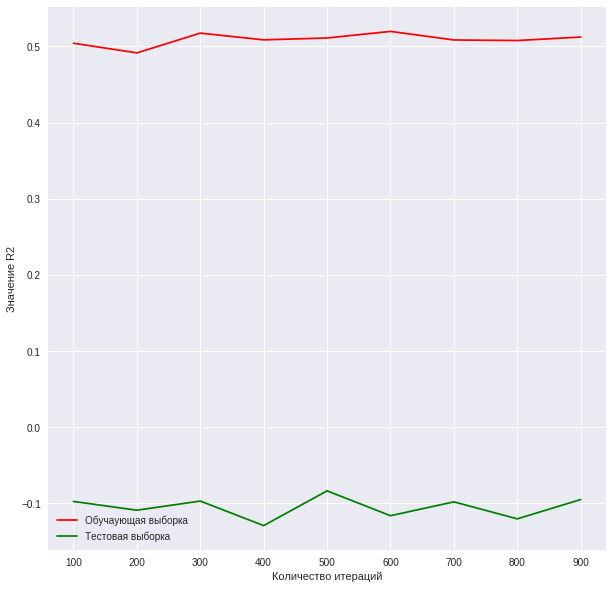

In [41]:
ns = np.arange(100, 1000, 100)
score_train = []
score_test = []
for n in ns:
    forest = ensemble.RandomForestRegressor(n_estimators = n).fit(train_data, train_labels)
    score_train.append(cross_validation.cross_val_score(forest, train_data, train_labels, 
                                                        scoring = 'r2',cv = 3).mean())
    score_test.append(cross_validation.cross_val_score(forest, test_data, test_labels,
                                                      scoring = 'r2', cv = 3).mean())
    
plt.figure(figsize = (10, 10))

plt.plot(ns, score_train, color = 'red', label = u'Обучаующая выборка')
plt.plot(ns, score_test, color = 'green', label = u'Тестовая выборка')
plt.xlabel(u'Количество итераций')
plt.ylabel(u'Значение R2')
plt.legend()
plt.show()

Как мы и предположили изначально, решающие деревья и их композиции не справились с задачей: коэффициент детерминации на тесте получился ниже нуля, а значит, такая модель даже хуже константной.

## Итоги и дальнейшие шаги

Очевидно, что задача построения качественной модели прогнозирования не выполнена ввиду отсутствия достаточного количества данных. При наличии большего количества времени стоило бы провести полноценную работу по отбору признаков. Для этого могло бы быть испольновано сингулярное разложение матрицы объектов-признаков или метод главных компонент. Качественное уменьшение размерности могло бы помочь построить более стабильную модель даже на небольшом количестве признаков.

Также можно потратить больше времени на улучшение самой модели. В случае значительного уменьшения количества признаков после понижения размерности можно попробовать другие, более сложные модели, например, случайный лес или градиентный бустинг.

Полезным могла бы быть более тщательная работа с неравномерно распределенными категориальным признаками. Ввиду малого количество объектов с некоторыми значениями признаков некоторые значения могли попасть в тест, но не попасть в обучение.